# Google colab/ Kaggle

Pour utiliser le google drive et avoir des informations sur le système utilisé.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

#chemin_google_drive = "drive/MyDrive/"

!cat /proc/cpuinfo | grep 'model name'
!cat /proc/meminfo | grep 'MemTotal'

chemin_train = "/kaggle/input/abc-dataset-train/"
chemin_validation = "/kaggle/input/abc-dataset-validation/"

model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
MemTotal:       16390784 kB


# Chargement fichier .ply

Pour charger un fichier.ply, on utilise la librarie plyfile (https://pypi.org/project/plyfile/). Note on utilisera plyfile seulement pour l'écriture des fichiers ply. La librarie tqdm permet d'avoir une barre de progression pour une boucle, ce qui est utile pour connaître le temps.

In [2]:
!pip install plyfile

In [3]:
from plyfile import PlyData, PlyElement
from tqdm import tqdm

In [4]:
with open(chemin_train+'0002.ply', 'rb') as f:
    plydata = PlyData.read(f)

# Visualisation fichier .ply

Pour confirmer le chargement, on utilise la fonction de scatter de matploblib pour visualiser le nuage de points (https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html).

In [5]:
import matplotlib.pyplot as plt

In [6]:
def afficher(plydata):
    x = plydata.elements[0].data['x']
    y = plydata.elements[0].data['y']
    z = plydata.elements[0].data['z']
    red = plydata.elements[0].data['red']
    green = plydata.elements[0].data['green']
    blue = plydata.elements[0].data['blue']
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection='3d')
    
    colors = [(r/255,g/255,b/255,1) for r,g,b in zip(red, green, blue)]
    ax.scatter(x, y, z, marker='.', s=1, c=colors)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()  

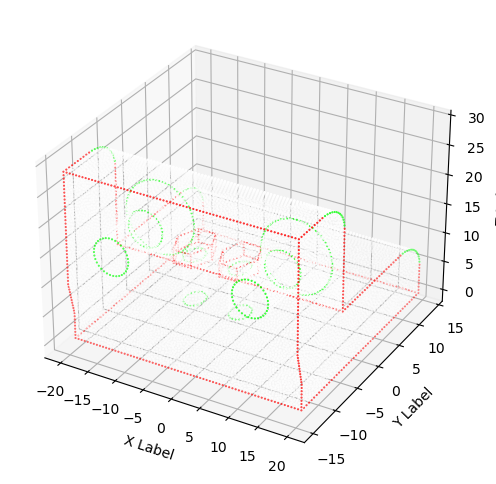

In [7]:
afficher(plydata)  

# Traitement des données .ply

On notera une différence avec le notebook d'avant, puisqu'on stocke les coordonnées x,y,z du point même si on ne les utilise pas dans le réseau de neurones, car on en a besoin lors de l'affichage.

In [8]:
import torch
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
class CustomDataset(Dataset):
    def __init__(self, ssm_data, lb_data, ply_data):
        self.hasLabel = True
        if lb_data == None:
            self.hasLabel = False
        self.labels = []
        self.data = self.load_data(ssm_data, lb_data)
        
        while "end_header" not in ply_data.readline():
            pass     
        
        self.points = np.loadtxt(ply_data, dtype=np.float32, ndmin=2, usecols=(0, 1, 2))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        coord = self.points[idx]
        sample = self.data[idx]
        if self.hasLabel:
            label = self.labels[idx]
        else:
            label = None
        return coord, sample, label

    def load_data(self, ssm_data, lb_data):
        
        while "#Data" not in ssm_data.readline():
            pass     
        
        data = np.loadtxt(ssm_data, dtype=np.float32, ndmin=2)
        
        data = np.nan_to_num(data)            
        
        if self.hasLabel:
            lb_data.readline()        
            self.labels = np.loadtxt(lb_data, dtype=np.int64) 

        data = torch.Tensor(data)       
        
        return data

# Définition du modèle

Pour rappel notre modèle prend en entrée un point et ses kppv et donne en sortie son type (si c'est un bord ou non). 

In [10]:
import torch.nn as nn

In [11]:
class PCEDNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers1 = nn.ModuleList([
            nn.Sequential(
                nn.Linear(12, 6),
                nn.Sigmoid()
            ) for _ in range(8)
        ])       
        
        self.layers2 = nn.ModuleList([
            nn.Sequential(
                nn.Linear(12, 6),
                nn.Sigmoid()
            ) for _ in range(4)
        ])       
        
        self.layers3 = nn.ModuleList([
            nn.Sequential(
                nn.Linear(12, 6),
                nn.Sigmoid()
            ) for _ in range(2)
        ])            
        
        self.mlp = nn.Sequential(
            nn.Linear(12, 16),
            nn.Sigmoid(),                        
            nn.Linear(16, 16),
            nn.Sigmoid(),            
            nn.Linear(16, 2)
        )        

    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 8, 12))
        
        x_concactene1 = torch.cat([self.layers1[i](x[:, i]) for i in range(8)], dim=1)
        x_concactene1 = torch.reshape(x_concactene1, (x.shape[0], 4, 12))
        
        x_concactene2 = torch.cat([self.layers2[i](x_concactene1[:, i]) for i in range(4)], dim=1)
        x_concactene2 = torch.reshape(x_concactene2, (x.shape[0], 2, 12))
        
        x_concactene3 = torch.cat([self.layers3[i](x_concactene2[:, i]) for i in range(2)], dim=1)
        x_concactene3 = torch.flatten(x_concactene3, start_dim=1)
        
        x_concactene3 = self.mlp(x_concactene3)
        
        return x_concactene3      

# Données du modèle

Pour l'entraînement on utilisera toutes les pièces du dossier train et pour la validation on utilisera toutes les pièces du dossier validation. Et on utilisera une pièce autre que celle utilisée dans le train pour donner un exemple de résultat (pour l'affichage).

In [12]:
from torch.utils.data import ConcatDataset

In [13]:
def charger_datasets(chemin, fichiers):
    datasets_list = []
    for fichier in tqdm(fichiers):
        with open(chemin+fichier+".lb", 'rb') as data_lb, \
             open(chemin+fichier+".ssm", 'r') as data_ssm, \
            open(chemin+fichier+".ply", 'r') as data_ply:
            dataset = CustomDataset(data_ssm, data_lb, data_ply)
        datasets_list.append(dataset)
    return datasets_list

Inutile d'activer le shuffle sur le validation_dataloader et afficher_dataloader.

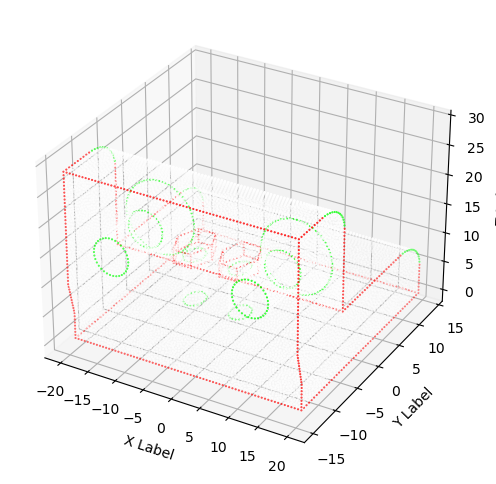

100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Fin chargement train


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]

Fin chargement validation


In [14]:
batch_size = 100

afficher_data_ply = PlyData.read(chemin_train+"0002.ply") #0002 0008
afficher(afficher_data_ply)

with open(chemin_train+"0002.lb", 'rb') as afficher_data_lb, \
    open(chemin_train+"0002.ssm", 'r') as afficher_data_ssm, \
    open(chemin_train+"0002.ply", 'r') as afficher_data_ply:
    afficher_dataset = CustomDataset(afficher_data_ssm, afficher_data_lb, afficher_data_ply)
    
afficher_dataloader = DataLoader(afficher_dataset, batch_size=batch_size, shuffle=False)

fichiers = ['0000', '0001', '0002', '0004', '0005', '0008', '0011', '0013', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0089', '0090', '0091', '0092', '0093', '0094', '0095', '0096', '0097', '0098', '0099', '0100', '0101', '0102', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0110', '0111', '0112', '0113', '0114', '0115', '0116', '0117', '0118', '0119', '0120', '0121', '0122', '0123', '0124', '0125', '0126', '0127', '0128', '0160', '0161', '0162', '0163', '0164', '0165', '0166', '0167', '0168', '0169', '0170', '0171', '0172', '0173', '0174', '0175', '0176', '0177', '0178', '0179', '0180', '0181', '0274', '0275', '0276', '0277', '0278', '0279', '0280', '0281', '0989', '0990', '0991', '0992', '0993', '0994', '0995', '0996', '0997', '0998']

train_dataloader = DataLoader(ConcatDataset(charger_datasets(chemin_train, fichiers)), batch_size=batch_size, shuffle=True)
print("Fin chargement train")

fichiers = ['0141', '0228', '0508', '0658', '0755', '0782', '0820', '0917', '0142', '0229', '0509', '0659', '0756', '0783', '0821', '0918', '0143', '0230', '0510', '0660', '0757', '0784', '0822', '0919', '0144', '0231', '0511', '0661', '0758', '0785', '0823', '0920', '0145', '0232', '0512', '0662', '0759', '0786', '0824', '0921', '0146', '0233', '0513', '0663', '0760', '0787', '0825', '0922', '0147', '0234', '0514', '0664', '0761', '0788', '0826', '0923', '0148', '0235', '0515', '0665', '0762', '0789', '0827', '0924', '0149', '0236', '0516', '0666', '0763', '0790', '0828', '0925', '0150', '0237', '0654', '0667', '0764', '0791', '0829', '0225', '0238', '0655', '0668', '0765', '0817', '0830', '0226', '0239', '0656', '0753', '0766', '0818', '0831', '0227', '0507', '0657', '0754', '0767', '0819', '0916']

validation_dataloader = DataLoader(ConcatDataset(charger_datasets(chemin_validation, fichiers)), batch_size=batch_size, shuffle=False)
print("Fin chargement validation")

# Accélération matérielle

Pour accélérer le temps d'apprentissage on utilisera un GPU (si c'est le cas).

In [15]:
device = ("cuda" if torch.cuda.is_available()
  else "mps" if torch.backends.mps.is_available()
  else "cpu")
print("Device:", device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

Device: cuda
Tesla P100-PCIE-16GB


# Apprentissage du modèle

On définit une fonction train (d'entraînement) avec arrêt prématuré et stockage des loss du dataset train et du dataset validation.

In [16]:
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [17]:
def train(model, num_epochs, train_dataloader, val_dataloader, criterion, optimizer, train_losses, val_losses, patience):
    count = 0
    best_val_loss = float('inf')  

    for epoch in tqdm(range(num_epochs)):        
        epoch_train_loss = 0
        epoch_val_loss = 0

        model.train()
        for (_, inputs, labels) in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_train_loss += loss.item()
            

        avg_epoch_train_loss = epoch_train_loss / len(train_dataloader)
        train_losses.append(avg_epoch_train_loss)

        model.eval()
        with torch.no_grad():
            for dataset in val_dataloader.dataset.datasets:
                inputs, labels = dataset.data.to(device),  torch.from_numpy(dataset.labels).to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                epoch_val_loss += loss.item()

            avg_epoch_val_loss = epoch_val_loss / len(val_dataloader)
            val_losses.append(avg_epoch_val_loss)


            if avg_epoch_val_loss < best_val_loss:
                best_val_loss = avg_epoch_val_loss
                best_model_weights = model.state_dict()
                count = 0
            else:
                count += 1
                if count >= patience:
                    print("Early stop")
                    model.load_state_dict(best_model_weights)
                    break

In [18]:
def afficher_loss(train_losses, val_losses):
    plt.plot(range(1,len(train_losses)+1), train_losses, marker='o', label='Train')
    plt.plot(range(1,len(val_losses)+1), val_losses, marker='o', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

Pour l'apprentissage, on utilise comme loss la Crossentropy et comme optimizer Adam. On utilisera aussi un arrêt prématuré de 5 epochs sur 100 epochs maximums. Et les hypers-paramètres suivant :

 12%|█▏        | 12/100 [1:09:35<8:30:17, 347.93s/it]

Early stop


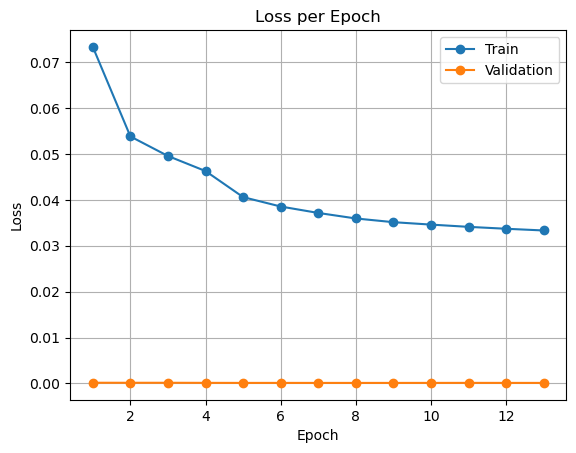

In [19]:
model = PCEDNet().to(device)

learning_rate = 0.001
num_epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

patience = 5

train_losses = []
val_losses = []

train(model, num_epochs, train_dataloader, validation_dataloader, criterion, optimizer, train_losses, val_losses, patience)

# Sauvegarde du modèle entraîné
# torch.save(model.state_dict(), "modele.pth")

afficher_loss(train_losses, val_losses)

## Résultats

On se réfère aux formules définies à la fin de l'article de PCEDNet.

In [20]:
def precision(TP,FP):
    if (TP + FP) != 0:
        return TP / (TP + FP)
    else:
        return 0

def rappel(TP,FN):
    if (TP + FN) != 0:
        return TP / (TP + FN)
    else:
        return 0

def f1_score(TP, FP, FN):
    precision_value = precision(TP, FP)
    recall_value = rappel(TP, FN)

    if (precision_value + recall_value) != 0:
        return 2 * (precision_value * recall_value) / (precision_value + recall_value)
    else:
        return 0



def mcc(TP, TN, FP, FN):
    numerator = (TP * TN) - (FP * FN)
    denominator = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
    if denominator != 0:
        return numerator / denominator
    else:
        return 0


def accuracy(TP, TN, FP, FN):
    total = TP + TN + FP + FN
    if total != 0:
        return (TP + TN) / total
    else:
        return 0


def iou(TP, FP, FN):
    union = TP + FP + FN
    if union != 0:
        return TP / union
    else:
        return 0

In [21]:
def resultat(model, validation_dataloader):
    fp = 0
    fn = 0
    tp = 0
    tn = 0

    list_predicted = []
    list_labels = []        
    
    model.eval()
    with torch.no_grad():
        for dataset in tqdm(validation_dataloader.dataset.datasets):
            inputs, labels = dataset.data.to(device), torch.from_numpy(dataset.labels).to(device)
        #for _, inputs, labels in tqdm(validation_dataloader):
        #    inputs, labels = inputs.to(device), labels.to(device)        
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            list_predicted.append(predicted)
            list_labels.append(labels)
    
    predicted = torch.cat(list_predicted, dim=0)
    labels = torch.cat(list_labels, dim=0)

    tp += torch.sum(torch.eq(predicted, labels) & torch.eq(labels, 1)).item()
    tn += torch.sum(torch.eq(predicted, labels) & torch.eq(labels, 0)).item()

    fp += torch.sum(torch.ne(predicted, labels) & torch.eq(labels, 0)).item()
    fn += torch.sum(torch.ne(predicted, labels) & torch.eq(labels, 1)).item()   

    print(fp, tp, fn, tn)

    print("Précision : ", precision(tp, fp))
    print("Rappel : ", rappel(tp, fn))
    print("F1 score :", f1_score(tp,fp,fn))
    print("MCC : ", mcc(tp, tn, fp, fn))
    print("Accuracy : ", accuracy(tp, tn, fp, fn))
    print("IoU : ", iou(tp, fp, fn))

In [22]:
resultat(model, validation_dataloader)

100%|██████████| 100/100 [00:00<00:00, 166.34it/s]

29644 207977 64236 4092744
Précision :  0.8752467164097449
Rappel :  0.7640230260861899
F1 score : 0.8158616333943989
MCC :  0.8066720334215061
Accuracy :  0.9786374235112585
IoU :  0.6889918073789907


## Affichage

In [23]:
def afficher_exemple(model, afficher_dataloader):
    model.eval()
    points = []

    with torch.no_grad():
        for coords, inputs, labels in afficher_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            for i,j in zip(coords,predicted):
                if j.tolist() == 0:
                    points.append((i[0], i[1], i[2], 255, 255, 255, 255))
                else:
                    points.append((i[0], i[1], i[2], 255, 0, 0, 255))


    properties = [('x', 'f4'), ('y', 'f4'), ('z', 'f4'), ('red', 'u1'), ('green', 'u1'), ('blue', 'u1'), ('alpha', 'u1')]

    points = np.array(points, dtype=properties)
    vertex_element = PlyElement.describe(points, 'vertex')

    new_ply_data = PlyData([vertex_element])

    #new_ply_data.write('resultats.ply')

    afficher(new_ply_data)

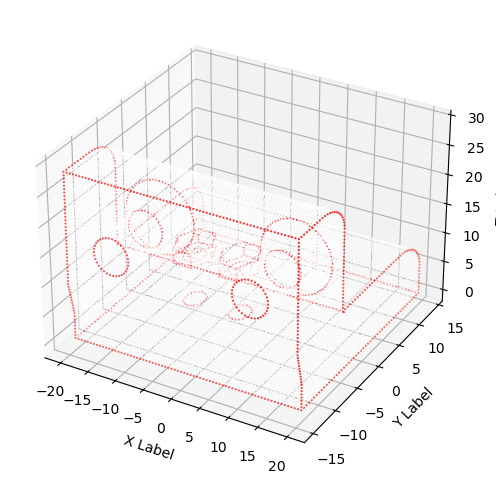

In [24]:
afficher_exemple(model, afficher_dataloader)